# ML Monitoring - Explore solutions to handle sudden drift due to covid

## Overview

Drifts are of generally 3 types

* Gradual drift - happens naturally as change in user behaviours over time
* Cyclic drift - happens due to seasonal effects
* Sudden drift - happens due to unexpected events with large scale impact changing user behaviours in matter of days to weeks.

Retraining model periodically or based on drift detection techniques is generally sufficient to handle gradual and cyclic drift. But to handle sudden drift retraining model may not be enough, since model is not trained on sufficient amount of data on the new behaviour patterns. In this notebook we will explore few of the solutions to handle sudden drift and compare them.

## Solutions to explore

* Is simply retraining model based on model performance decay and drift detection sufficient?
* Retrain model with instance weightage. Give higher weighted to most recent training examples and least to oldest. Exponential decay will be used for instance weightage
* Retrain model with adaptive window. Use only last 12 month data to train model
* Retrain model with adaptive window and expoential decay based instance weightage
* Generate synthetic data based on newly available behaviour pattern and retrain model

## Dataset:

* Contains warehouse demand data from 2017-01-01 to 2020-11-15
* Working with preprocessed data
* No data leakage as missing values were filled without requirement of any transformation

## Assumptions

* Initial model deployment on march 2019
* True labels/ actual demand available over the weekend
* Model monitored on monthly basis

## Libraries

In [39]:
import pandas as pd
import numpy as np
import scipy as sp
import calendar
from datetime import date,datetime,timedelta
import time
from sklearn.model_selection import train_test_split
from rdt import HyperTransformer
import xgboost as xgb
from matplotlib import pyplot as plt
import traceback
import shap
import logging
from importlib import reload
import logging
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from evidently import ColumnMapping
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataDriftProfileSection, NumTargetDriftProfileSection
import plotly.graph_objects as go
import plotly.express as px
import os
import json
import mlflow
from functools import wraps
from mlflow.tracking import MlflowClient
import plotly.io as pio
# remove static rendering to allow interactive mode
#pio.renderers.default = "notebook"
pio.renderers.default = "svg"
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# set up logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [4]:
# mlflow runner
def mlflow_runner(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # log into MLflow
        client = MlflowClient()
        experiment_name = kwargs['experiment_name']
        run_name = kwargs['run_name']
        try:
            mlflow.set_experiment(experiment_name)
        except Exception:
            logging.error('Experiment does not exists')
            logging.error('Stack trace:{}'.format(traceback.format_exc()))
            experiment_id = mlflow.create_experiment(experiment_name)
            mlflow.set_experiment(experiment_name)
        finally:
            run = mlflow.active_run()
            nested = False if run is None else True
            with mlflow.start_run(run_name=run_name, nested=nested) as run:
                    rv = func(*args, **kwargs)   
            return rv

    return wrapper

## Data

### Load data

In [6]:
df = pd.read_csv('cpp_demand_forecasting_clean_data_v2.csv', index_col=0)

In [7]:
logging.info(f'dataset shape : {df.shape}')

08:57:43 INFO:dataset shape : (13315, 33)


In [8]:
# set random state
rng = np.random.RandomState(0)

In [9]:
df.head(2)

,date,warehouse_ID,Latitude,Longitude,Product_Type,year,month,is_weekend,is_warehouse_closed,daily_dispatch_count,...,statewise_land_area_per_sqmile,statewise_population_per_sqmile,statewise_geographic_region,geographic_region_division,statewise_median_age,statewise_median_household_income,total_count,yearly_count,monthly_count,weekly_count
ID,,,,,,,,,,,,,,,,,,,,,
0x2710,2017-01-01,WH_0x3e9,41.681471,-72.794746,Type_A,2017,1,Yes,No,5.5,...,4842,744.722016,new_england,north_east,41.2,78833,0,0,0,0
0x33e6,2017-01-01,WH_0x3ea,38.749077,-105.183060,Type_A,2017,1,Yes,No,6.1,...,103642,56.078318,mountain,west,37.3,41053,0,0,0,0


In [10]:
df.date = pd.to_datetime(df.date)

<b> Data available during initial model deployment is from 2017-01-01 to 2019-02-28

In [11]:
intial_df = df[df.date < datetime(2019,3,1)]

In [12]:
# Split the dataset
train_df, test_df = train_test_split(intial_df,
                                     test_size=0.3,
                                     shuffle=False,
                                     random_state=rng)
eval_df, serve_df = train_test_split(test_df,
                                     test_size=0.5,
                                     shuffle=False,
                                     random_state=rng)

In [13]:
logging.info(f'train_df shape : {train_df.shape}')
logging.info(f'eval_df shape : {eval_df.shape}')
logging.info(f'serve_df shape : {serve_df.shape}')

08:57:52 INFO:train_df shape : (2794, 33)
08:57:52 INFO:eval_df shape : (599, 33)
08:57:52 INFO:serve_df shape : (599, 33)


### Data preprocessing

In [14]:
def split_features_target(df):
    target =  'daily_dispatch_count'
    drop_feats = ['weekly_dispatch_count']
    y = df[target]
    X = df.drop(columns = drop_feats+[target])
    return X,y

In [15]:
X,y = split_features_target(train_df)
X_eval,y_eval = split_features_target(eval_df)
X_serve,y_serve = split_features_target(serve_df)

### Data transformation

In [16]:
ht = HyperTransformer()

In [17]:
ht.detect_initial_config(data=X)

Detecting a new config from the data ... SUCCESS
Setting the new config ... SUCCESS
Config:
{
    "sdtypes": {
        "date": "datetime",
        "warehouse_ID": "categorical",
        "Latitude": "numerical",
        "Longitude": "numerical",
        "Product_Type": "categorical",
        "year": "numerical",
        "month": "numerical",
        "is_weekend": "categorical",
        "is_warehouse_closed": "categorical",
        "week": "numerical",
        "state": "categorical",
        "county": "categorical",
        "state_cases": "numerical",
        "state_deaths": "numerical",
        "county_cases": "numerical",
        "county_deaths": "numerical",
        "day_of_week": "numerical",
        "days_since_warehouse_started": "numerical",
        "state_abbr": "categorical",
        "is_holiday": "numerical",
        "statewise_population": "numerical",
        "statewise_land_area_per_sqmile": "numerical",
        "statewise_population_per_sqmile": "numerical",
        "statew

In [18]:
ht.fit(X)
X_transformed = ht.transform(X)
X_eval_transformed = ht.transform(X_eval)
X_serve_transformed = ht.transform(X_serve)

## Modelling

In [19]:
def get_dmatrix(X, y=None, weight = None):
    
    return xgb.DMatrix(X, y, feature_names=X.columns, weight = weight)

In [22]:
def get_booster(dmat_train, dmat_test, params= None, xgb_model = None):
    params = {'objective': 'reg:squarederror', 'booster':'gbtree'} if params is None else params
    booster = xgb.train(
            params = params,
            dtrain = dmat_train,
            evals = [(dmat_train, "train"), (dmat_test, "test")],
            verbose_eval = False,
            xgb_model = xgb_model) # Xgb model to be loaded before training (allows training continuation).
    return booster

In [23]:
#@mlflow_runner
def fit_model(X,y, X_test,y_test, params=None,mlflow_log = False, experiment_name=None, run_name = None, train_weight = None, test_weight = None, xgb_model = None):
    dmat_train = get_dmatrix(X, y, train_weight)
    dmat_test = get_dmatrix(X_test, y_test, test_weight)
    reg = get_booster(dmat_train, dmat_test, params, xgb_model)
    if mlflow_log:
        mlflow.log_dict(json.loads(reg.save_config()),'xgboost_regressor_params')
        
    return reg

In [24]:
reg_normal = fit_model(X_transformed,y, X_eval_transformed,y_eval, mlflow_log=True,experiment_name='warehouse_demand_forecasting',run_name=str(int(time.mktime(datetime.now().timetuple()))))

#### Adaptive model training

Train model based on certatin window. 6 month or 1 year for example

In [25]:
def filter_data_to_last_n_days(data, num_days):

    original_data = ht.reverse_transform(data)
    start = original_data['date'].iloc[-1] - timedelta(days=num_days)
    filtered_data = original_data[original_data.date >= start]
    retransformed_data = ht.transform(filtered_data)

    return retransformed_data

def filter_features_target(X, y, num_days):

    X_filtered = filter_data_to_last_n_days(X, num_days)
    y_filtered = y.loc[X_filtered.index]
    
    return X_filtered, y_filtered

def adaptive_model_training(X, y , X_test, y_test, num_days, model = None, mlflow_log=True):
    X_filtered, y_filtered = filter_features_target(X, y , num_days)
    reg_adaptive = fit_model(X_filtered, y_filtered, X_test, y_test, mlflow_log=mlflow_log,experiment_name='warehouse_demand_forecasting',run_name=str(int(time.mktime(datetime.now().timetuple()))), 
                            xgb_model=model)
    return reg_adaptive


In [26]:
#filtered_x = filter_data_to_last_n_days(X_transformed, 180)

In [27]:
reg_adaptive_window_6_month = adaptive_model_training (X_transformed,y, X_eval_transformed,y_eval, 180)

In [28]:
reg_adaptive_window_1_year = adaptive_model_training (X_transformed,y, X_eval_transformed,y_eval, 365)

#### Instance weights based training

Assign higher instance weights to most recenet training examples and little value to older examples. We can use exponential decay to assign instance weights

##### Eponential decay

In [29]:
def model_func(t, A, K, C):
    return A * np.exp(K * t) + C

def fit_exp_linear(t, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    return A, K

def plot(ax, t, y, noisy_y, fit_y, orig_parms, fit_parms):
    A0, K0, C0 = orig_parms
    A, K, C = fit_parms

    ax.plot(t, fit_y, 'b-',
      label='Function:\n $y = %0.2f e^{%0.2f t} + %0.2f$' % (A, K, C))
    ax.plot(t, noisy_y, 'ro')
    ax.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)

def exponential_decay(train_dataset_length, exp_coeffecient, bias):
    # Actual parameters
    A0, K0, C0 = train_dataset_length, exp_coeffecient, bias

    # Generate some data based on these
    tmin, tmax = 0, 0.5
    num = train_dataset_length
    t = np.linspace(tmin, tmax, num)
    y = model_func(t, A0, K0, C0)

    # Add noise
    noisy_y = y + 0.5 * (np.random.random(num) - 0.5)

    fig = plt.figure()
    ax1 = fig.add_subplot(2, 1, 1)


    # Linear Fit (Note that we have to provide the y-offset ("C") value!!
    A, K = fit_exp_linear(t, y, C0)
    fit_y_linear = model_func(t, A, K, C0)
    plot(ax1,t, y, noisy_y, fit_y_linear, (A0, K0, C0), (A, K, 0))
    ax1.set_title('Linear Fit')

    plt.show()

    return fit_y_linear

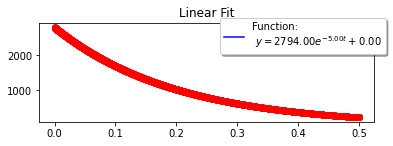

In [30]:
fit_y_linear = exponential_decay(X_transformed.shape[0],-5,2)

In [31]:
def fit_model_with_instance_weights(X, y, X_test, y_test, exp_coeffecient, bias, params = None, model = None , mlflow_log=True):
    
    train_instance_weights = exponential_decay(X.shape[0], exp_coeffecient, bias)
    reg_exponential_decay =  fit_model(X, y, X_test, y_test, params , train_weight=train_instance_weights, mlflow_log=mlflow_log,experiment_name='warehouse_demand_forecasting',run_name=str(int(time.mktime(datetime.now().timetuple()))),
                                    xgb_model=model)
    return reg_exponential_decay

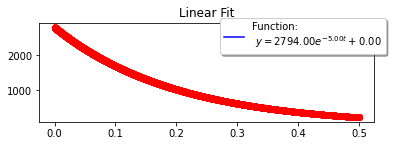

In [32]:
reg_exponential_decay = fit_model_with_instance_weights(X_transformed,y, X_eval_transformed,y_eval , -5, 2)

#### Model evaluation

#### Metric selection

In Demand forecasting , models are exepcted to handle special events. 

* MAE doesn't penalize model for underperformance of during special events. 
* MAPE is not a good metric for demand forecasting. MAPE divides each error individually by the demand, so it is skewed: high errors during low-demand periods will significantly impact MAPE.
* MSE is not scaled to the original error (as the error is squared), resulting in a KPI that we cannot relate to the original demand scale.
* RMSE is sensitive to outliers and does penalize model for underperformance on special events.
<div><b>We will convert RMSE to RMSE% to scale RMSE to average demand. Otherwise we will get skewed results during very low demand period. This will also make the results more interpretable</b></div>

In [40]:
def rewrite_name(df_type, error_type):
    return f"{df_type}{'_'}{error_type}"

def get_scores(y_actual, y_predicted,df_type='train'):
    #y_predicted = np.expm1(y_predicted)
    #y_actual = np.expm1(y_actual)
    rmse = mean_squared_error(y_actual, y_predicted, squared=False)
    rmse_scaled_to_demand = rmse / (np.sum(y_actual / y_actual.shape[0])) * 100
    mse = mean_squared_error(y_actual, y_predicted, squared=True)
    #mae = mean_absolute_error(y_actual, y_predicted)
    mape = mean_absolute_percentage_error(y_actual, y_predicted)
    scores = {rewrite_name(df_type, 'rmse'):rmse, rewrite_name(df_type, 'rmse_scaled_to_average_demand'):rmse_scaled_to_demand}
    return scores

def dataset_results(X,y, model, df_type):

    y_pred = model.predict(X)
    
    return get_scores(y,y_pred,df_type)
    
    

#### Final model trained using data from 2017-01-01 to 2019-02-28

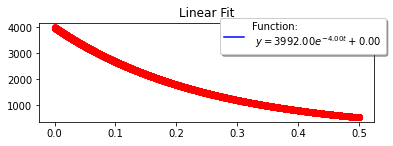

In [34]:
final_X, final_y = split_features_target(intial_df)
ht.fit(final_X)
final_X_transform = ht.transform(final_X)
reg_normal = fit_model(final_X_transform,final_y, X_eval_transformed,y_eval, mlflow_log=True,experiment_name='warehouse_demand_forecasting',run_name=str(int(time.mktime(datetime.now().timetuple()))))
reg_exponential_decay = fit_model_with_instance_weights(final_X_transform,final_y, X_eval_transformed,y_eval, -4, 2)
reg_adaptive_window_6_month = adaptive_model_training (final_X_transform,final_y, X_eval_transformed,y_eval, 180)
reg_adaptive_window_12_month = adaptive_model_training (final_X_transform,final_y, X_eval_transformed,y_eval, 365)

In [35]:
final_X_transform.head()

,date.value,warehouse_ID.value,Latitude.value,Longitude.value,Product_Type.value,year.value,month.value,is_weekend.value,is_warehouse_closed.value,week.value,...,statewise_land_area_per_sqmile.value,statewise_population_per_sqmile.value,statewise_geographic_region.value,geographic_region_division.value,statewise_median_age.value,statewise_median_household_income.value,total_count.value,yearly_count.value,monthly_count.value,weekly_count.value
ID,,,,,,,,,,,,,,,,,,,,,
0x2710,1.483229e+18,0.151804,41.681471,-72.794746,0.295842,2017,1,0.857966,0.5,52,...,4842,744.722016,0.667335,0.681864,41.2,78833,0,0,0,0
0x33e6,1.483229e+18,0.455411,38.749077,-105.183060,0.295842,2017,1,0.857966,0.5,52,...,103642,56.078318,0.257766,0.257766,37.3,41053,0,0,0,0
0x2711,1.483315e+18,0.151804,41.681471,-72.794746,0.295842,2017,1,0.357966,0.5,1,...,4842,744.722016,0.667335,0.681864,41.2,78833,1,1,1,0
0x33e7,1.483315e+18,0.455411,38.749077,-105.183060,0.295842,2017,1,0.357966,0.5,1,...,103642,56.078318,0.257766,0.257766,37.3,41053,1,1,1,0
0x2712,1.483402e+18,0.151804,41.681471,-72.794746,0.295842,2017,1,0.357966,0.5,1,...,4842,744.722016,0.667335,0.681864,41.2,78833,2,2,2,1


### Feature attribution weighted drift detection

In [41]:
def get_feature_importance(model, X):
    # DF, based on which importance is checked

    # Explain model predictions using shap library:
    explainer = shap.TreeExplainer(model)
    shap_scores = explainer.shap_values(X)

    # mean of absolute shap values for every feature
    mean_abs_shap_values = pd.Series(
        np.abs(shap_scores).mean(axis=0),
        index=X.columns).sort_values(ascending=False)
    return mean_abs_shap_values

In [42]:
def get_relative_feature_importance_to_max(feature_importance):
    
    # maximum feature importance
    max_feature_importance = feature_importance.max()

    # relative_feature_importance_to_max is relative feature importance w.r.t max_feature_importance
    relative_feature_importance_to_max = feature_importance / max_feature_importance
    return relative_feature_importance_to_max.to_dict()

In [43]:
numerical_features = [
    'statewise_population_per_sqmile', 'state_cases', 'state_deaths'
]
numerical_features_value = [
    feature + '.value' for feature in numerical_features
]
categorical_features = [
    'warehouse_ID', 'Product_Type', 'is_weekend', 'is_warehouse_closed',
    'state', 'day_of_week', 'is_holiday', 'county'
]
categorical_features_value = [
    feature + '.value' for feature in categorical_features
]
column_mapping = ColumnMapping(id='ID',
                               datetime='date',
                               numerical_features=numerical_features_value,
                               categorical_features=categorical_features_value,
                               task='regression',
                               target='daily_dispatch_count',
                               prediction='y_pred')

In [44]:
def get_drift_profile(reference, production, profile, mlflow_log=False):

    drift_profile = Profile(sections=[profile()])
    drift_profile.calculate(reference,
                                 production,
                                 column_mapping=column_mapping)
    report = drift_profile.json()
    drift_profile_report = json.loads(report)
    
    if mlflow_log:
        if profile == DataDriftProfileSection:
            name = 'data_drift_profile'
        elif profile == NumTargetDriftProfileSection:
            name = 'num_target_drift_profile'
        else:
            pass
        mlflow.log_dict(drift_profile_report, f"{name}.json")
    
    
    return drift_profile_report

In [45]:
def get_data_drift(drift_profile):

    drifts = []
    for feature in column_mapping.numerical_features + column_mapping.categorical_features:
        drifts.append(
            (feature, drift_profile['data_drift']['data']['metrics'][feature]['drift_score'], 
             drift_profile['data_drift']['data']['metrics'][feature]['stattest_name'], 
             drift_profile['data_drift']['data']['metrics'][feature]['drift_detected']))
    return  pd.DataFrame(
        drifts,
        columns=['feature', 'drift_score', 'stattest_name', 'drift_detected'])

data_drift_profile = get_drift_profile(X_transformed.sample(300), X_eval_transformed.sample(300),
                                           DataDriftProfileSection, mlflow_log=False)
drift_scores = get_data_drift(data_drift_profile)

In [48]:
def get_weighted_data_drift_score(drift, feature_importance, relative_feature_importance_to_max_dict, threshold, stattest_type):
    
    #feature_importance
    drift['feature_importance'] = drift['feature'].map(feature_importance)
    
    # map relative feature importance
    drift['relative_feature_importance'] = drift['feature'].map(relative_feature_importance_to_max_dict)
    if stattest_type == 'p_value':
        # relative feature importance weighted drift score
        inverse_feature_importance_wrt_max_feature_importance = (drift.relative_feature_importance.max() / drift.relative_feature_importance)
        drift['feature_importance_weighted_drift_score'] = (drift.drift_score * inverse_feature_importance_wrt_max_feature_importance).replace(np.inf, 1)
        #drift['feature_importance_weighted_drift_score'] = drift.apply(lambda x:1 if x['relative_feature_importance']<=0.0 else x['feature_importance_weighted_drift_score'], axis=1)
        # drift detection based on the weighted drift score based on threshold
        drift['feature_importance_weighted_drift_detected'] = drift[
            'feature_importance_weighted_drift_score'] < threshold
    elif stattest_type == 'distance':
        # relative feature importance weighted drift score
        drift['feature_importance_weighted_drift_score'] = drift[
            'relative_feature_importance'] * drift['drift_score']

        # drift detection based on the weighted drift score based on threshold
        drift['feature_importance_weighted_drift_detected'] = drift[
            'feature_importance_weighted_drift_score'] > threshold
    else:
        raise ValueError(f'invalid stattype {stattest_type}')

    return drift

In [49]:
def is_weighted_data_drift_detected(data_drift_profile, production,  model):
    drift_detected = False
    
    feature_importance = get_feature_importance(model, production)
    # relative feature importance based on mean shap values
    relative_feature_importance_to_max_dict = get_relative_feature_importance_to_max(feature_importance)
    drift_scores = get_data_drift(data_drift_profile)
    stattest_type = drift_scores['stattest_name'].iloc[0].split()[1]
    if stattest_type == 'p_value':
        threshold = 0.05
    else:
        threshold = 0.1
    weighted_drift_scores = get_weighted_data_drift_score(drift_scores, feature_importance, relative_feature_importance_to_max_dict,
                                                     threshold, stattest_type)

    if weighted_drift_scores['feature_importance_weighted_drift_detected'].sum(
    ) > 0:
        drift_detected = True
    else:
        drift_detected = False
    return drift_detected, weighted_drift_scores

In [50]:
def overlay_distribution(data1, data2, feature,  opacity=0.5, plot_display = True, mlflow_log=False):
    normalization_type = 'probability density'
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=data1, name="training",
                  histnorm=normalization_type))
    fig.add_trace(go.Histogram(x=data2, name="production",
                  histnorm=normalization_type))
    feature = feature.split('.')[0]
    # Overlay both histograms
    fig.update_layout(barmode='overlay', title=feature+" Distribution",
                      xaxis_title=feature,
                      yaxis_title=normalization_type, autosize=False,
                      width=700,
                      height=300)
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=opacity)
    if mlflow_log:
        mlflow.log_figure(fig, f"{feature}_Distribution.html")
    if plot_display:
        fig.show()


In [51]:
def display_drifted_features(reference, production, drift_df, plot_display = False, mlflow_log = False, verbose = True):
    reference_rdt = ht.reverse_transform(reference)
    production_rdt = ht.reverse_transform(production)
    for index, row in drift_df.iterrows():
        if row['feature_importance_weighted_drift_detected']:
            if verbose:

                logging.info(f"drift detected for {row['feature']}")
                logging.info(f"drift_score : {row['drift_score']}")
                logging.info(f"stattest_name : {row['stattest_name']}")
                logging.info(f"raw_feature_importance : {row['feature_importance']}") 
                logging.info(f"relative_feature_importance : {row['relative_feature_importance']}") 
                logging.info(f"feature_importance_weighted_drift_score : {row['feature_importance_weighted_drift_score']}")
            
            overlay_distribution(reference_rdt[row['feature'].split('.')[0]], production_rdt[row['feature'].split('.')[0]], row['feature'], opacity = .4, 
            plot_display = plot_display, mlflow_log=True)
        if mlflow_log:
                mlflow.log_param(f"{row['feature']}_feature_importance_weighted_drift_detected", row['feature_importance_weighted_drift_detected'])
                mlflow.log_param(f"{row['feature']}_drift_score", row['drift_score'])
                mlflow.log_param(f"{row['feature']}_stattest_name", row['stattest_name'])
                mlflow.log_param(f"{row['feature']}_raw_feature_importance", row['feature_importance'])
                mlflow.log_param(f"{row['feature']}_relative_feature_importance", row['relative_feature_importance'])
                mlflow.log_param(f"{row['feature']}_feature_importance_weighted_drift_score", row['feature_importance_weighted_drift_score'])

    

In [52]:
def display_target_drift(y_reference, y_production, target_name, target_drift_detected, drift_score, stattest_type, plot_display = False, mlflow_log = False, verbose=True):
    if verbose:
        logging.info(f"Target drift detected for for {target_name}")
        logging.info(f"drift_score : {drift_score}")
        logging.info(f"stattest_name : {stattest_type}")
    if mlflow_log:
        mlflow.log_param(f"{target_name}_drift_detected", target_drift_detected)
        mlflow.log_param(f"{target_name}_target_drift_score", drift_score)
        mlflow.log_param(f"{target_name}_target_stattest_name", stattest_type)
    overlay_distribution(y_reference, y_production, target_name, opacity = .4, plot_display = plot_display, mlflow_log=True)
            

#### Test for target drift

In [53]:
def determine_test_type(reference):

    num_data = reference.shape[0]

    if num_data <= 1000:
        return 'p_value'
    else:
        return 'distance'

In [54]:
def test_target_drift(X_reference, y_reference, X_production, y_production, plot_display = False, mlflow_log = False, verbose = True):
    target_drift_detected = False
    # get target drift report
    if column_mapping.task == 'regression':
        profile = NumTargetDriftProfileSection
        drift_name = 'num_target_drift'
    else:
        pass
    target_drift_profile = get_drift_profile(X_reference.join(y_reference), X_production.join(y_production), profile, mlflow_log)
    
    drift_score = target_drift_profile[drift_name]['data']['metrics']['target_drift']
    target_name = target_drift_profile[drift_name]['data']['utility_columns']['target']
    stattest_type = determine_test_type(X_reference)
    if stattest_type == 'p_value':
        threshold = 0.05
        if drift_score <= threshold:

            target_drift_detected = True

    else:
        threshold = 0.1
        if drift_score >= threshold:

            target_drift_detected = True
   
    if mlflow_log:
        display_target_drift(y_reference, y_production, target_name, target_drift_detected, drift_score, stattest_type, plot_display, mlflow_log = True, verbose = verbose)
    return target_drift_detected
      

In [55]:
def test_for_drift(X_reference, y_reference, X_production, y_production, model, plot_display = False, mlflow_log = False, verbose = True):

    
    target_drift_detected = test_target_drift(X_reference, y_reference, X_production, y_production, mlflow_log, verbose)

    logging.info(f"target drift detect: {target_drift_detected}")
    # get data drift report
    data_drift_profile = get_drift_profile(X_reference, X_production,
                                           DataDriftProfileSection, mlflow_log)
    # data drift detected?
    drift_detected, drift_df = is_weighted_data_drift_detected(data_drift_profile,
                                                     X_production,  model)
    
    if drift_detected:
        logging.info('data set drift detected')
        display_drifted_features(X_reference, X_production, drift_df, plot_display, mlflow_log, verbose=verbose)
    else:
        logging.info('drift not detected')
    drift_detected = drift_detected or target_drift_detected
    return drift_detected

In [56]:
@mlflow_runner
def test_mlflow(experiment_name, run_name = None):
    # Log parameters
    mlflow.log_param("begin", datetime(2020,1,2))
    mlflow.log_param("end", datetime(2022,1,2))
    mlflow.log_dict(X_transformed.sample(500).to_dict(), 'input_features.json')
    mlflow.log_dict(X_eval_transformed.sample(500).to_dict(), 'target.json')
    return test_for_drift(X_transformed.sample(500), y.sample(500), X_eval_transformed.sample(500), y_eval.sample(500) ,reg_normal, plot_display = True, mlflow_log = True)


In [ ]:
#test_mlflow(experiment_name = 'mlflow drift detection test', run_name=str(int(time.mktime(datetime.now().timetuple()))))

## Simulate model on data from 2019-03-01 to 2020-11-15

In [57]:
simulate_df = df[df.date >= datetime(2019,3,1)]

In [58]:
@mlflow_runner
def simulate_experiment_with_timeframe(df, X_train, y_train, reg_trained, preds, experiment_name, run_name, time_frame, run_num, exponential_decay = False, exp_decay_coeff = 0, bias=0, 
                                        adaptive_window = 0, plot_display =False, verbose = False):
    """
    timeframe: weekly / monthly
    """
    # Get tf data
    #global final_X_transform
    #global final_y
    #global reg_final
    row = df.iloc[0]
    dt = row['date']
    if time_frame == 'weekly':
        start = (dt - timedelta(days=calendar.weekday(dt.year,dt.month,dt.day))).to_pydatetime()
        end = start + timedelta(days=time_frame)
    elif time_frame == 'monthly':
        start = datetime(dt.year, dt.month, 1)
        end = datetime(dt.year, dt.month, calendar.monthrange(dt.year, dt.month)[1])
    sub_df = df.set_index('date')[start:end]
    sub_df = sub_df.reset_index().set_index('ID')
    df = df[(df.date.dt.date > end.date())]
    print(f'Experiment of {time_frame} timeframe, run {run_num}')
    print('---------------------------------')
    print(f"Experiment start date : {start}")
    print(f"Experiment end_date : {end}")
    #mlflow.log_param('experiment_run_sequence',tf_run_sequence)
    mlflow.log_param('experiment_start_date',start)
    mlflow.log_param('experiment_end_date',end)
    
    # Transform sub_df to X, y
    X_prod,y_prod = split_features_target(sub_df)
    X_prod_transformed = ht.transform(X_prod)
    
    mlflow.log_dict(X_prod_transformed.to_dict(), 'input_features.json')
    mlflow.log_dict(y_prod.to_dict(), 'target.json')
    # tf_prediction
    tf_predictions = reg_trained.predict(get_dmatrix(X_prod_transformed))
    
    mlflow.log_dict(pd.Series(tf_predictions,name=y_prod.name, index = y_prod.index).to_dict(),f'tf_{time_frame}_predictions.json')
    # Predict for X,y
    scores_dict = get_scores(y_prod,tf_predictions,f"tf_{time_frame}")
    mlflow.log_metrics(scores_dict)
    preds.extend(tf_predictions.tolist())
    ht.fit(X_prod)
    reference_data = X_train.sample(n = X_prod_transformed.shape[0])
    reference_target = y_train.loc[y_train.index.isin(reference_data.index)].reindex(reference_data.index)
    #print(reference_data.shape[0])
    mlflow.log_param('experiment_data_size',reference_data.shape[0])
    #print(reference_target.shape[0])
    mlflow.log_param('experiment_target_size',reference_target.shape[0])
    
    if test_for_drift(reference_data, reference_target, X_prod_transformed, y_prod, reg_trained, plot_display, mlflow_log=True, verbose = verbose):
        # retrain model
        # test for drift an
        if exponential_decay:
            print('instance weight based retraining')
            reg_trained = fit_model_with_instance_weights(X_train, y_train, X_prod_transformed, y_prod, exp_decay_coeff, bias, mlflow_log = False)
        elif adaptive_window > 0:
            print('adapative window based retraining')
            reg_trained = adaptive_model_training(X_train, y_train, X_prod_transformed, y_prod , adaptive_window , mlflow_log = False)
        else:
            print('reg normal retraining')
            reg_trained = fit_model(X_prod_transformed,y_prod, X_prod_transformed,y_prod, mlflow_log=False,experiment_name='warehouse_demand_forecasting',
            run_name=str(int(time.mktime(datetime.now().timetuple()))), xgb_model = reg_trained)
    else:
        logging.info('No Drift detection')
    X_train = X_train.append(X_prod_transformed)
    y_train = y_train.append(y_prod)
    #print(X_train.shape)
    #print(y_train.shape)
    return df, preds, X_train, y_train, reg_trained    

In [59]:
def simulate_model(df, X_train, y_train, reg_trained, experiment_name, run_name, time_frame, exponential_decay = False, exp_decay_coeff = 0, bias=0, adaptive_window = 0, plot_display =False):
    """
    timeframe: weekly / monthly
    """
    preds = []
    df = df.reset_index()
    current_df = df
    run_num = 1
    run_name = f'run_tf_{time_frame}_{run_name}_{str(int(time.mktime(datetime.now().timetuple())))}'
    while current_df.shape[0] > 0:
        
        current_df, preds, X_train, y_train, reg_trained = simulate_experiment_with_timeframe(current_df, X_train, y_train, reg_trained, preds, experiment_name = experiment_name,run_name = run_name, 
        time_frame = time_frame, run_num = run_num, exponential_decay = exponential_decay, exp_decay_coeff = exp_decay_coeff, bias = bias, adaptive_window = adaptive_window, plot_display = plot_display)
        run_num +=1
    return preds 

2022/07/12 09:00:40 INFO mlflow.tracking.fluent: Experiment with name 'drift_solutions_experimentation' does not exist. Creating a new experiment.


Experiment of monthly timeframe, run 1
---------------------------------
Experiment start date : 2019-03-01 00:00:00
Experiment end_date : 2019-03-31 00:00:00


09:00:41 INFO:target drift detect: True
09:00:41 INFO:data set drift detected


310
310
instance weight based retraining


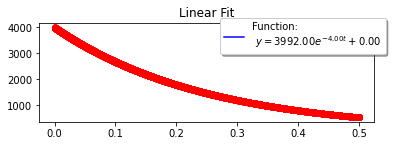

Experiment of monthly timeframe, run 2
---------------------------------
Experiment start date : 2019-04-01 00:00:00
Experiment end_date : 2019-04-30 00:00:00


09:00:43 INFO:target drift detect: False
09:00:43 INFO:data set drift detected


300
300
instance weight based retraining


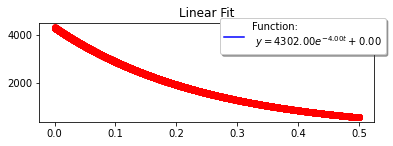

Experiment of monthly timeframe, run 3
---------------------------------
Experiment start date : 2019-05-01 00:00:00
Experiment end_date : 2019-05-31 00:00:00


09:00:45 INFO:target drift detect: False


370
370


09:00:45 INFO:data set drift detected


instance weight based retraining


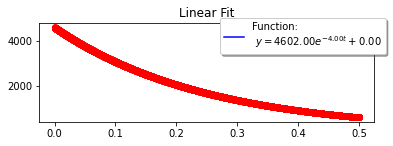

Experiment of monthly timeframe, run 4
---------------------------------
Experiment start date : 2019-06-01 00:00:00
Experiment end_date : 2019-06-30 00:00:00


09:00:47 INFO:target drift detect: True


360
360


09:00:47 INFO:data set drift detected


instance weight based retraining


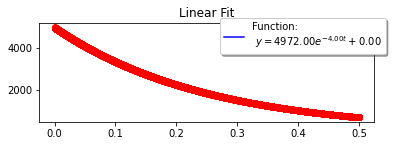

Experiment of monthly timeframe, run 5
---------------------------------
Experiment start date : 2019-07-01 00:00:00
Experiment end_date : 2019-07-31 00:00:00


09:00:49 INFO:target drift detect: True
09:00:49 INFO:data set drift detected


372
372
instance weight based retraining


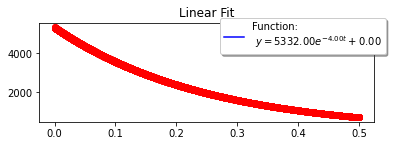

Experiment of monthly timeframe, run 6
---------------------------------
Experiment start date : 2019-08-01 00:00:00
Experiment end_date : 2019-08-31 00:00:00


09:00:50 INFO:target drift detect: False


372
372


09:00:51 INFO:data set drift detected


instance weight based retraining


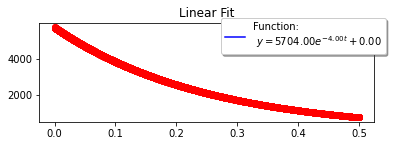

Experiment of monthly timeframe, run 7
---------------------------------
Experiment start date : 2019-09-01 00:00:00
Experiment end_date : 2019-09-30 00:00:00


09:00:52 INFO:target drift detect: False


360
360


09:00:52 INFO:data set drift detected


instance weight based retraining


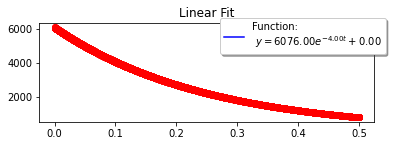

Experiment of monthly timeframe, run 8
---------------------------------
Experiment start date : 2019-10-01 00:00:00
Experiment end_date : 2019-10-31 00:00:00


09:00:54 INFO:target drift detect: False
09:00:54 INFO:data set drift detected


372
372
instance weight based retraining


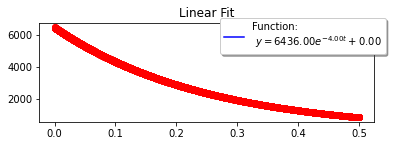

Experiment of monthly timeframe, run 9
---------------------------------
Experiment start date : 2019-11-01 00:00:00
Experiment end_date : 2019-11-30 00:00:00


09:00:55 INFO:target drift detect: False


360
360


09:00:56 INFO:data set drift detected


instance weight based retraining


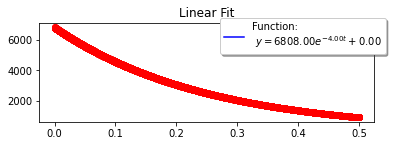

Experiment of monthly timeframe, run 10
---------------------------------
Experiment start date : 2019-12-01 00:00:00
Experiment end_date : 2019-12-31 00:00:00


09:00:57 INFO:target drift detect: True
09:00:57 INFO:data set drift detected


372
372
instance weight based retraining


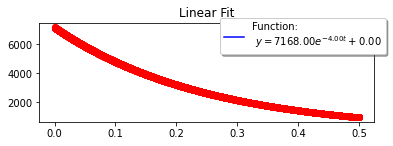

Experiment of monthly timeframe, run 11
---------------------------------
Experiment start date : 2020-01-01 00:00:00
Experiment end_date : 2020-01-31 00:00:00


09:00:59 INFO:target drift detect: True


432
432


09:00:59 INFO:data set drift detected


instance weight based retraining


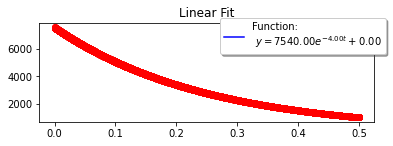

Experiment of monthly timeframe, run 12
---------------------------------
Experiment start date : 2020-02-01 00:00:00
Experiment end_date : 2020-02-29 00:00:00


09:01:00 INFO:target drift detect: True


462
462


09:01:00 INFO:data set drift detected


instance weight based retraining


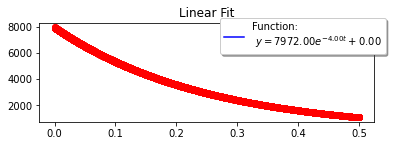

Experiment of monthly timeframe, run 13
---------------------------------
Experiment start date : 2020-03-01 00:00:00
Experiment end_date : 2020-03-31 00:00:00


09:01:02 INFO:target drift detect: True


496
496


09:01:02 INFO:data set drift detected


instance weight based retraining


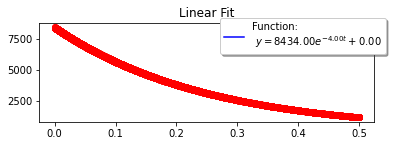

Experiment of monthly timeframe, run 14
---------------------------------
Experiment start date : 2020-04-01 00:00:00
Experiment end_date : 2020-04-30 00:00:00


09:01:04 INFO:target drift detect: True


480
480


09:01:04 INFO:data set drift detected


instance weight based retraining


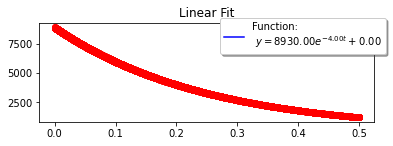

Experiment of monthly timeframe, run 15
---------------------------------
Experiment start date : 2020-05-01 00:00:00
Experiment end_date : 2020-05-31 00:00:00


09:01:06 INFO:target drift detect: True


556
556


09:01:06 INFO:data set drift detected


instance weight based retraining


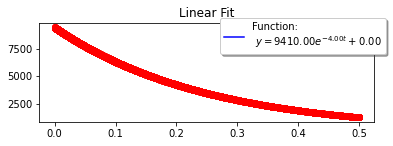

Experiment of monthly timeframe, run 16
---------------------------------
Experiment start date : 2020-06-01 00:00:00
Experiment end_date : 2020-06-30 00:00:00


09:01:07 INFO:target drift detect: True


598
598


09:01:08 INFO:data set drift detected


instance weight based retraining


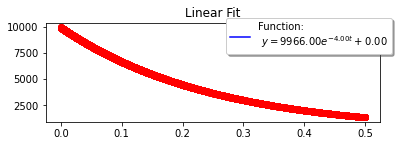

Experiment of monthly timeframe, run 17
---------------------------------
Experiment start date : 2020-07-01 00:00:00
Experiment end_date : 2020-07-31 00:00:00


09:01:09 INFO:target drift detect: True


620
620


09:01:10 INFO:data set drift detected


instance weight based retraining


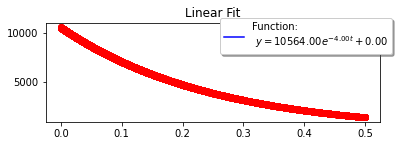

Experiment of monthly timeframe, run 18
---------------------------------
Experiment start date : 2020-08-01 00:00:00
Experiment end_date : 2020-08-31 00:00:00


09:01:11 INFO:target drift detect: True


620
620


09:01:12 INFO:data set drift detected


instance weight based retraining


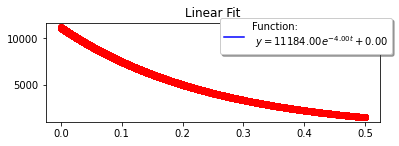

Experiment of monthly timeframe, run 19
---------------------------------
Experiment start date : 2020-09-01 00:00:00
Experiment end_date : 2020-09-30 00:00:00


09:01:14 INFO:target drift detect: True


600
600


09:01:14 INFO:data set drift detected


instance weight based retraining


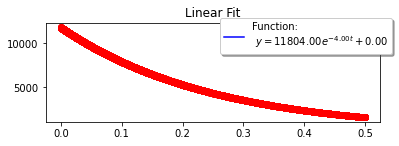

Experiment of monthly timeframe, run 20
---------------------------------
Experiment start date : 2020-10-01 00:00:00
Experiment end_date : 2020-10-31 00:00:00


09:01:16 INFO:target drift detect: True


620
620


09:01:16 INFO:data set drift detected


instance weight based retraining


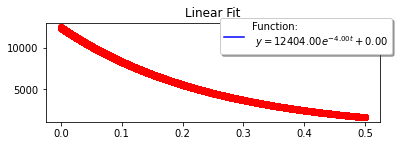

Experiment of monthly timeframe, run 21
---------------------------------
Experiment start date : 2020-11-01 00:00:00
Experiment end_date : 2020-11-30 00:00:00


09:01:18 INFO:target drift detect: True


291
291


09:01:18 INFO:data set drift detected


instance weight based retraining


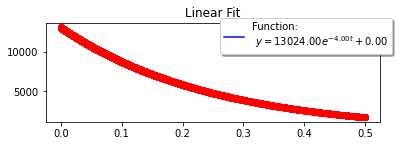

In [60]:
preds = simulate_model(simulate_df, final_X_transform, final_y, reg_exponential_decay, experiment_name='drift_solutions_experimentation', 
                        run_name='run_tf_monthly_retrain_model_with_instance_weights_when_drift_detected',time_frame = 'monthly', exponential_decay = True, exp_decay_coeff = -4, bias = 2)

In [62]:
preds = simulate_model(simulate_df, final_X_transform, final_y, reg_normal, experiment_name='drift_solutions_experimentation', run_name='retrain_model_when_drift_detected_adaptive_window_12_month',
                        time_frame = 'monthly', adaptive_window = 365)

Experiment of monthly timeframe, run 1
---------------------------------
Experiment start date : 2019-03-01 00:00:00
Experiment end_date : 2019-03-31 00:00:00


09:01:48 INFO:target drift detect: True


310
310


09:01:48 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 2
---------------------------------
Experiment start date : 2019-04-01 00:00:00
Experiment end_date : 2019-04-30 00:00:00


09:01:50 INFO:target drift detect: False


300
300


09:01:50 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 3
---------------------------------
Experiment start date : 2019-05-01 00:00:00
Experiment end_date : 2019-05-31 00:00:00


09:01:51 INFO:target drift detect: False
09:01:51 INFO:data set drift detected


370
370
adapative window based retraining
Experiment of monthly timeframe, run 4
---------------------------------
Experiment start date : 2019-06-01 00:00:00
Experiment end_date : 2019-06-30 00:00:00


09:01:53 INFO:target drift detect: True
09:01:53 INFO:data set drift detected


360
360
adapative window based retraining
Experiment of monthly timeframe, run 5
---------------------------------
Experiment start date : 2019-07-01 00:00:00
Experiment end_date : 2019-07-31 00:00:00


09:01:54 INFO:target drift detect: True


372
372


09:01:55 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 6
---------------------------------
Experiment start date : 2019-08-01 00:00:00
Experiment end_date : 2019-08-31 00:00:00


09:01:56 INFO:target drift detect: False


372
372


09:01:56 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 7
---------------------------------
Experiment start date : 2019-09-01 00:00:00
Experiment end_date : 2019-09-30 00:00:00


09:01:58 INFO:target drift detect: False


360
360


09:01:58 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 8
---------------------------------
Experiment start date : 2019-10-01 00:00:00
Experiment end_date : 2019-10-31 00:00:00


09:02:00 INFO:target drift detect: False


372
372


09:02:00 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 9
---------------------------------
Experiment start date : 2019-11-01 00:00:00
Experiment end_date : 2019-11-30 00:00:00


09:02:02 INFO:target drift detect: False


360
360


09:02:02 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 10
---------------------------------
Experiment start date : 2019-12-01 00:00:00
Experiment end_date : 2019-12-31 00:00:00


09:02:04 INFO:target drift detect: True


372
372


09:02:04 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 11
---------------------------------
Experiment start date : 2020-01-01 00:00:00
Experiment end_date : 2020-01-31 00:00:00


09:02:05 INFO:target drift detect: True


432
432


09:02:06 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 12
---------------------------------
Experiment start date : 2020-02-01 00:00:00
Experiment end_date : 2020-02-29 00:00:00


09:02:07 INFO:target drift detect: True


462
462


09:02:07 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 13
---------------------------------
Experiment start date : 2020-03-01 00:00:00
Experiment end_date : 2020-03-31 00:00:00


09:02:09 INFO:target drift detect: True


496
496


09:02:09 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 14
---------------------------------
Experiment start date : 2020-04-01 00:00:00
Experiment end_date : 2020-04-30 00:00:00


09:02:10 INFO:target drift detect: True


480
480


09:02:11 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 15
---------------------------------
Experiment start date : 2020-05-01 00:00:00
Experiment end_date : 2020-05-31 00:00:00


09:02:12 INFO:target drift detect: True


556
556


09:02:12 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 16
---------------------------------
Experiment start date : 2020-06-01 00:00:00
Experiment end_date : 2020-06-30 00:00:00


09:02:15 INFO:target drift detect: True


598
598


09:02:15 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 17
---------------------------------
Experiment start date : 2020-07-01 00:00:00
Experiment end_date : 2020-07-31 00:00:00


09:02:16 INFO:target drift detect: True


620
620


09:02:17 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 18
---------------------------------
Experiment start date : 2020-08-01 00:00:00
Experiment end_date : 2020-08-31 00:00:00


09:02:18 INFO:target drift detect: True


620
620


09:02:18 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 19
---------------------------------
Experiment start date : 2020-09-01 00:00:00
Experiment end_date : 2020-09-30 00:00:00


09:02:20 INFO:target drift detect: True


600
600


09:02:20 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 20
---------------------------------
Experiment start date : 2020-10-01 00:00:00
Experiment end_date : 2020-10-31 00:00:00


09:02:21 INFO:target drift detect: True


620
620


09:02:21 INFO:data set drift detected


adapative window based retraining
Experiment of monthly timeframe, run 21
---------------------------------
Experiment start date : 2020-11-01 00:00:00
Experiment end_date : 2020-11-30 00:00:00


09:02:23 INFO:target drift detect: True


291
291


09:02:23 INFO:data set drift detected


adapative window based retraining


In [110]:
preds = simulate_model(simulate_df, final_X_transform, final_y, reg_normal, experiment_name='drift_solutions_experimentation', run_name='retrain_model_when_drift_detected',time_frame = 'monthly')

Experiment of monthly timeframe, run 1
---------------------------------
Experiment start date : 2019-03-01 00:00:00
Experiment end_date : 2019-03-31 00:00:00


11:27:53 INFO:target drift detect: True
11:27:53 INFO:data set drift detected


310
310
reg normal retraining
Experiment of monthly timeframe, run 2
---------------------------------
Experiment start date : 2019-04-01 00:00:00
Experiment end_date : 2019-04-30 00:00:00


11:27:54 INFO:target drift detect: False


300
300


11:27:54 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 3
---------------------------------
Experiment start date : 2019-05-01 00:00:00
Experiment end_date : 2019-05-31 00:00:00


11:27:56 INFO:target drift detect: False


370
370


11:27:56 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 4
---------------------------------
Experiment start date : 2019-06-01 00:00:00
Experiment end_date : 2019-06-30 00:00:00


11:27:57 INFO:target drift detect: False


360
360


11:27:57 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 5
---------------------------------
Experiment start date : 2019-07-01 00:00:00
Experiment end_date : 2019-07-31 00:00:00


11:27:59 INFO:target drift detect: True


372
372


11:27:59 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 6
---------------------------------
Experiment start date : 2019-08-01 00:00:00
Experiment end_date : 2019-08-31 00:00:00


11:28:01 INFO:target drift detect: False


372
372


11:28:01 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 7
---------------------------------
Experiment start date : 2019-09-01 00:00:00
Experiment end_date : 2019-09-30 00:00:00


11:28:02 INFO:target drift detect: False


360
360


11:28:03 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 8
---------------------------------
Experiment start date : 2019-10-01 00:00:00
Experiment end_date : 2019-10-31 00:00:00


11:28:05 INFO:target drift detect: True


372
372


11:28:05 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 9
---------------------------------
Experiment start date : 2019-11-01 00:00:00
Experiment end_date : 2019-11-30 00:00:00


11:28:07 INFO:target drift detect: False


360
360


11:28:07 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 10
---------------------------------
Experiment start date : 2019-12-01 00:00:00
Experiment end_date : 2019-12-31 00:00:00


11:28:09 INFO:target drift detect: True


372
372


11:28:09 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 11
---------------------------------
Experiment start date : 2020-01-01 00:00:00
Experiment end_date : 2020-01-31 00:00:00


11:28:11 INFO:target drift detect: True


432
432


11:28:12 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 12
---------------------------------
Experiment start date : 2020-02-01 00:00:00
Experiment end_date : 2020-02-29 00:00:00


11:28:13 INFO:target drift detect: True


462
462


11:28:14 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 13
---------------------------------
Experiment start date : 2020-03-01 00:00:00
Experiment end_date : 2020-03-31 00:00:00


11:28:15 INFO:target drift detect: True


496
496


11:28:16 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 14
---------------------------------
Experiment start date : 2020-04-01 00:00:00
Experiment end_date : 2020-04-30 00:00:00


11:28:18 INFO:target drift detect: True


480
480


11:28:19 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 15
---------------------------------
Experiment start date : 2020-05-01 00:00:00
Experiment end_date : 2020-05-31 00:00:00


11:28:21 INFO:target drift detect: True


556
556


11:28:22 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 16
---------------------------------
Experiment start date : 2020-06-01 00:00:00
Experiment end_date : 2020-06-30 00:00:00


11:28:24 INFO:target drift detect: True


598
598


11:28:25 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 17
---------------------------------
Experiment start date : 2020-07-01 00:00:00
Experiment end_date : 2020-07-31 00:00:00


11:28:26 INFO:target drift detect: True


620
620


11:28:27 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 18
---------------------------------
Experiment start date : 2020-08-01 00:00:00
Experiment end_date : 2020-08-31 00:00:00


11:28:29 INFO:target drift detect: True


620
620


11:28:30 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 19
---------------------------------
Experiment start date : 2020-09-01 00:00:00
Experiment end_date : 2020-09-30 00:00:00


11:28:32 INFO:target drift detect: True


600
600


11:28:33 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 20
---------------------------------
Experiment start date : 2020-10-01 00:00:00
Experiment end_date : 2020-10-31 00:00:00


11:28:34 INFO:target drift detect: True


620
620


11:28:36 INFO:data set drift detected


reg normal retraining
Experiment of monthly timeframe, run 21
---------------------------------
Experiment start date : 2020-11-01 00:00:00
Experiment end_date : 2020-11-30 00:00:00


11:28:37 INFO:target drift detect: True


291
291


11:28:38 INFO:data set drift detected


reg normal retraining


#### Experiment monthly performance comparision plot

In [203]:
expirement_results = mlflow.search_runs(experiment_names=['drift_solutions_experimentation'])
expirement_results.set_index('params.experiment_end_date',inplace=True)
expirement_results.index = pd.to_datetime(expirement_results.index)
expirement_results.sort_index(ascending=True,inplace=True)
expirement_results = expirement_results[~expirement_results.index.isna()]

In [204]:
expirement_results.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.tf_monthly_rmse,metrics.tf_monthly_rmse_scaled_to_average_demand,params.is_holiday.value_feature_importance_weighted_drift_detected,params.state.value_feature_importance_weighted_drift_detected,...,params.is_warehouse_closed.value_feature_importance_weighted_drift_detected,params.experiment_start_date,params.state_deaths.value_relative_feature_importance,params.day_of_week.value_stattest_name,params.state_deaths.value_drift_score,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.parentRunId,tags.mlflow.runName,tags.mlflow.source.type
params.experiment_end_date,,,,,,,,,,,,,,,,,,,,,
2019-03-31,502e05b26909400597fc1330d02a7280,1,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-12 03:30:40.613000+00:00,2022-07-12 03:30:42.977000+00:00,0.709921,11.696184,False,False,...,False,2019-03-01 00:00:00,0.0,chi-square p_value,1.0,d:\anaconda\envs\anaconda_env\lib\site-package...,shree,8e69f81e4fd14150a805715ebb7da4f1,run_tf_monthly_run_tf_monthly_retrain_model_wi...,LOCAL
2019-03-31,9c2c07fd2d4f407e824890024d6e8d6a,1,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-12 03:31:47.751000+00:00,2022-07-12 03:31:49.534000+00:00,0.739961,12.191110,False,False,...,False,2019-03-01 00:00:00,0.0,chi-square p_value,1.0,d:\anaconda\envs\anaconda_env\lib\site-package...,shree,8e69f81e4fd14150a805715ebb7da4f1,run_tf_monthly_retrain_model_when_drift_detect...,LOCAL
2019-03-31,4d3132c1fa3b4c65b6f2f29fa033008b,1,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-12 03:31:20.241000+00:00,2022-07-12 03:31:22.225000+00:00,0.751977,12.389070,False,False,...,False,2019-03-01 00:00:00,0.0,chi-square p_value,1.0,d:\anaconda\envs\anaconda_env\lib\site-package...,shree,8e69f81e4fd14150a805715ebb7da4f1,run_tf_monthly_retrain_model_when_drift_detect...,LOCAL
2019-03-31,73e801925c214b53af4c4e3fd148e7b4,1,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-12 03:32:24.646000+00:00,2022-07-12 03:32:25.644000+00:00,0.751977,12.389070,False,False,...,False,2019-03-01 00:00:00,0.0,chi-square p_value,1.0,d:\anaconda\envs\anaconda_env\lib\site-package...,shree,8e69f81e4fd14150a805715ebb7da4f1,run_tf_monthly_retrain_model_when_drift_detect...,LOCAL
2019-03-31,e37c3f6dab4c456a86bbaff83bf53a49,1,FINISHED,file:///C:/Users/shree/projects/ML_Monitoring/...,2022-07-12 05:57:52.721000+00:00,2022-07-12 05:57:54.017000+00:00,0.751977,12.389070,False,False,...,False,2019-03-01 00:00:00,0.0,chi-square p_value,1.0,d:\anaconda\envs\anaconda_env\lib\site-package...,shree,8e69f81e4fd14150a805715ebb7da4f1,run_tf_monthly_retrain_model_when_drift_detect...,LOCAL


In [205]:
def get_latest_run_for_experiment_by_run_name(run_name):
    check_numeric = pd.Series(expirement_results[expirement_results['tags.mlflow.runName'].str.startswith(run_name)]['tags.mlflow.runName'].unique()[::-1]).str.split(f'{run_name}_',expand=True)[1]
    most_recent_row = check_numeric[check_numeric.str.isnumeric()].sort_values(ascending = False).astype(int).iloc[0]
    return f'{run_name}_{most_recent_row}'

In [206]:
run_tf_monthly_retrain_model_when_drift_detected_exp_results = expirement_results[expirement_results['tags.mlflow.runName'] == get_latest_run_for_experiment_by_run_name('run_tf_monthly_retrain_model_when_drift_detected')]

In [207]:
run_tf_monthly_retrain_model_with_instance_weights_when_drift_detected = expirement_results[expirement_results['tags.mlflow.runName'] == get_latest_run_for_experiment_by_run_name('run_tf_monthly_run_tf_monthly_retrain_model_with_instance_weights_when_drift_detected')]

In [208]:
run_tf_monthly_retrain_model_when_drift_detected_adaptive_window_12_month = expirement_results[expirement_results['tags.mlflow.runName'] == get_latest_run_for_experiment_by_run_name('run_tf_monthly_retrain_model_when_drift_detected_adaptive_window_12_month')]

In [213]:
def get_date_time_range_data(df, start,end):
    if start and end:
        return df[start:end]
    elif start is None and end:
        return df[:end]
    elif start and end is None:
        return df[start:]
    else:
        return df
        

In [244]:
def save_plots(figure, title):
    if not os.path.exists('plots'):
        os.mkdir('plots')
    figure.write_html(os.path.join('plots','_'.join(title.split())+'.html'))

In [245]:
# plot function
def plot_model_decay(title, start=None,end=None):
    fig = go.Figure()



    x_axis = get_date_time_range_data(run_tf_monthly_retrain_model_when_drift_detected_exp_results, start,end).reset_index()['params.experiment_end_date']
    fig.add_trace(go.Scatter(x=x_axis, y=get_date_time_range_data(run_tf_monthly_retrain_model_when_drift_detected_exp_results, start,end)['metrics.tf_monthly_rmse'], name="retrain model when drift detected", mode="lines+markers"))
    fig.add_trace(go.Scatter(x=x_axis, y=get_date_time_range_data(run_tf_monthly_retrain_model_with_instance_weights_when_drift_detected, start,end)['metrics.tf_monthly_rmse'], 
                            name="retrain model with instance weights when drift detected" , mode="lines+markers"))
    fig.add_trace(go.Scatter(x=x_axis, y=get_date_time_range_data(run_tf_monthly_retrain_model_when_drift_detected_adaptive_window_12_month, start,end)['metrics.tf_monthly_rmse'], 
                            name="retrain model when drift detected with data of only last12 month window" , mode="lines+markers"))
    # Edit the layout
    fig.update_layout(title=title,
                    xaxis_title='Date',
                    yaxis_title='monthly_rmse',
                    width=1500,
                    height=500,
                    )

    save_plots(fig, title)
    fig.show()

#### Model decay before covid

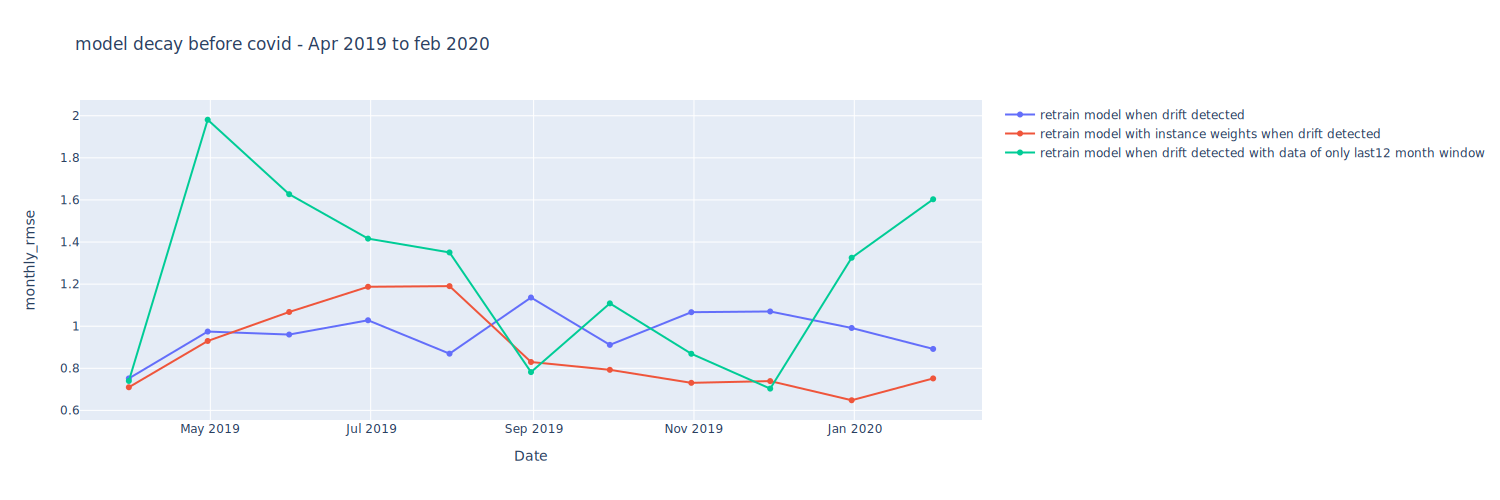

In [246]:

plot_model_decay('model decay before covid - Apr 2019 to feb 2020', None, datetime(2020,2,28))

#### Model decay after covid

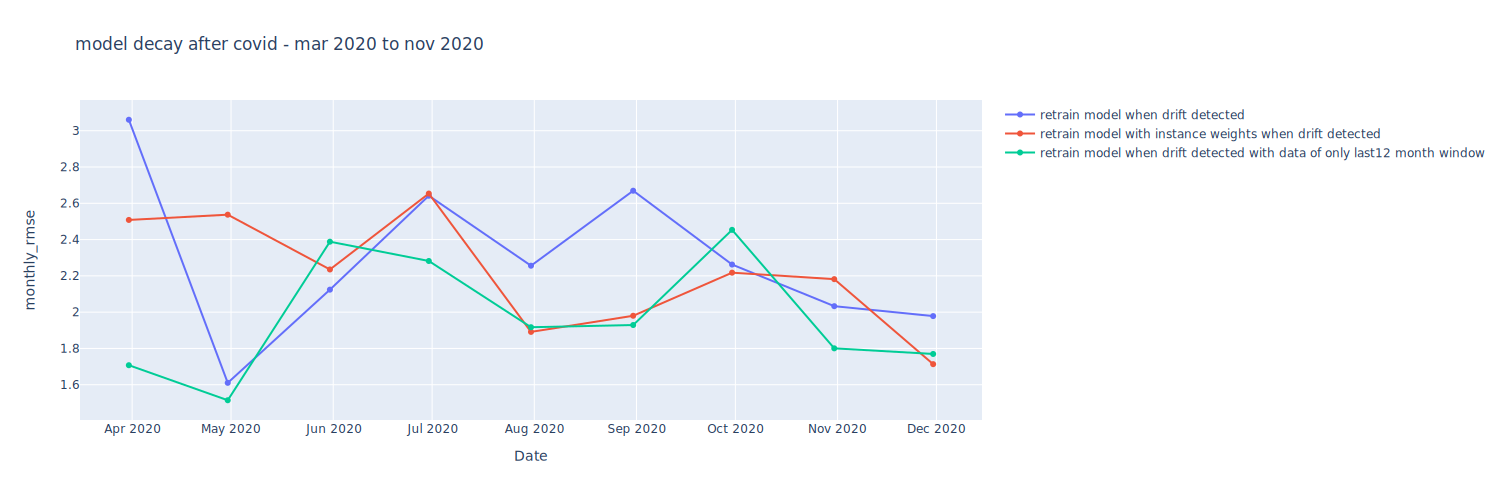

In [247]:
plot_model_decay('model decay after covid - mar 2020 to nov 2020', datetime(2020,3,1), None)

#### Overall model decay

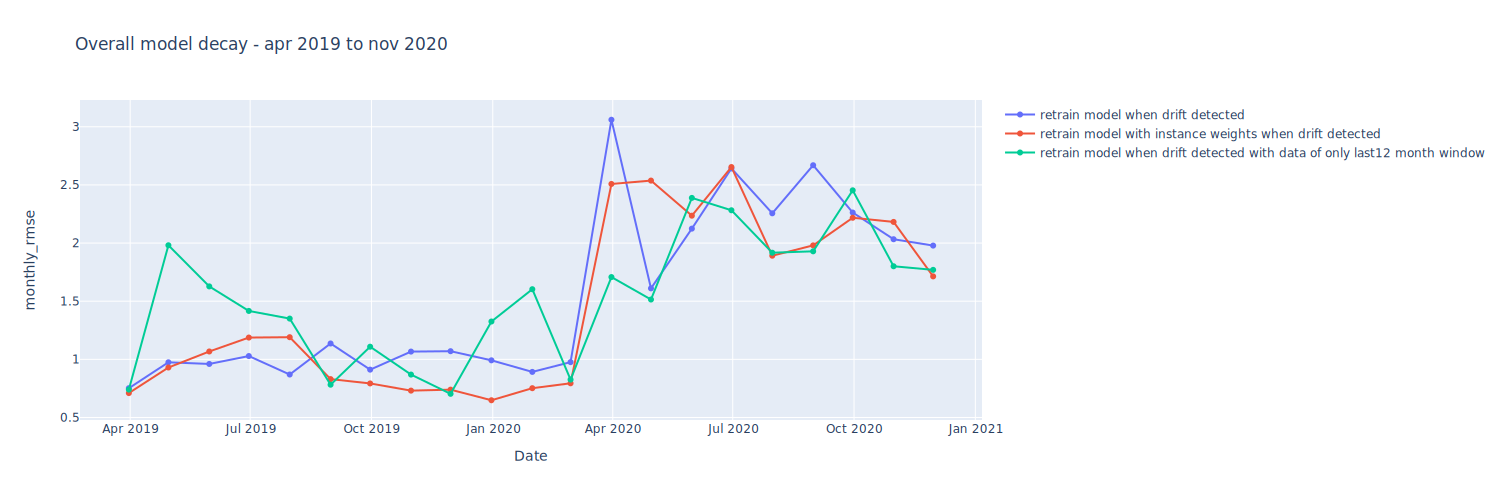

In [248]:
plot_model_decay('Overall model decay - apr 2019 to nov 2020')

##### Overall best performance was retraining model with exponential decay based instance weights. Instance weights based solution works well for gradual model decay which is expected over time.
##### Best at handling sudden drift(sharp model decay) during covid was adaptive window solution. Adaptive window solution uses recent data as a result likey to capture more relevant patterns.